In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import camap
%matplotlib inline

In [3]:
#import dautils

nlat = 276
nlon = 466
#basin = np.memmap("/project/uma_colin_gleason/yuta/CaMa-Flood_v395b_20191030/map/MSR_03min/basin.bin", shape=(nlat, nlon), mode="r", dtype=np.int32)
#basin
#map2vec, vec2lat, vec2lon = dautils.vectorize_2dIndex(basin)

In [4]:
effective_rivers_path = "~/yuta/RiDiA/data/MS-RiDiA/rawdata/widths/good_rivers.csv"
effective_rivers = pd.read_csv(effective_rivers_path)
segmentIds = effective_rivers["segmentID"].tolist()
segmentInds = effective_rivers["segmentInd"].tolist()
segmentKeys = ["{0}_{1}".format(segmentIds[i], segmentInds[i])
               for i in range(len(segmentIds))]

In [5]:
cs_path = "../../../data/MS-RiDiA/rawdata/widths/missouri_joined_gt120m_v01.shp"
cs_missouri = gpd.read_file(cs_path)
segmentIds_all = cs_missouri["segmentID"].astype(np.int64).tolist()
segmentInds_all = cs_missouri["segmentInd"].tolist()
segmentKeys_all = ["{0}_{1}".format(segmentIds_all[i], segmentInds_all[i])
                   for i in range(len(segmentIds_all))]
cs_missouri["segmentKeys"] = segmentKeys_all
cs_missouri = cs_missouri.set_index("segmentKeys")

In [6]:
cs_effective = pd.DataFrame(cs_missouri.loc[segmentKeys,
                            ["lat_dd", "lon_dd", "width_m"]])
#cs_effective.to_csv("./mapout/missouri_goodrivers_coordinates.csv")

In [7]:
mapper = camap.Camap()
mapper.register("./camainfo_missouri.json")
lats = cs_effective["lat_dd"].tolist()
lons = cs_effective["lon_dd"].tolist()
out = mapper.mapgrid(lons, lats)

This is a toolkit to geomap dataset onto CaMa-Flood maps.
Register your json file first via .register(configjson).


In [8]:
cs_effective["MSR_03min_glon"] = out[0]
cs_effective["MSR_03min_glat"] = out[1]
cs_effective.to_csv("./mapout/missouri_goodrivers_coordinates.csv")

In [9]:
out_t = np.array(out[0:2]).T
temporaly_id = ["{0}_{1}".format(c[0], c[1]) for c in out_t]

In [10]:
print("Before dropping duplication: {0}".format(len(temporaly_id)))
print("After dropping duplication: {0}".format(len(set(temporaly_id))))

Before dropping duplication: 773
After dropping duplication: 387


In [11]:
undef = -9999
widths_all = pd.read_csv("../../../data/MS-RiDiA/rawdata/widths/missouri_widths_v01.csv", index_col=0)
widths_all = widths_all.loc[segmentKeys].replace(0, np.nan)
cs_effective["mean_from_Landsat"] = widths_all.mean(axis=1)

In [99]:
cs_effective["coarsegrid"] = temporaly_id
cs_effective["segment_keys"] = cs_effective.index
cs_effective.groupby("coarsegrid")["mean_from_Landsat", "segment_keys"].max()
d = cs_effective.groupby("coarsegrid")["mean_from_Landsat", "segment_keys"].max().mean_from_Landsat.values
print(np.where(d>700))
cs_effective.groupby("coarsegrid")["mean_from_Landsat", "segment_keys"].max().iloc[201, :]

(array([ 90,  96, 169, 172, 173, 187, 188, 189, 191, 193, 195, 201, 202,
       204, 332]),)


mean_from_Landsat    700.248
segment_keys         63_1905
Name: 353_144, dtype: object

In [13]:
cs_effective.groupby("coarsegrid")["mean_from_Landsat", "segment_keys"].max().to_csv("./mapout/cama_mapped_cs.csv", header=True, index=True)
np.array(out).astype(np.int64).flatten().tofile("./mapout/camapoints.bin")

In [14]:
mapped_csv = pd.read_csv("./mapout/cama_mapped_cs.csv")
mapped_grids = mapped_csv["coarsegrid"]
mapped_css = mapped_csv["segment_keys"].tolist()
mapped_grids

0      -1000_-1000
1           100_84
2           101_85
3           103_42
4           103_85
5           104_42
6           104_85
7           105_42
8           105_86
9           106_86
10          107_42
11          107_86
12          108_41
13          108_85
14          109_42
15          109_43
16          111_43
17          112_44
18          113_45
19          114_45
20          115_45
21          116_45
22          117_45
23          119_45
24          119_46
25          120_46
26          122_78
27          123_78
28          124_78
29          125_77
          ...     
357          65_46
358          68_44
359          69_43
360          70_42
361          71_42
362          72_42
363          73_42
364          78_39
365          79_38
366          79_83
367          80_38
368          80_83
369          81_38
370          82_37
371          82_83
372          83_37
373          84_37
374          84_83
375          85_37
376          85_38
377          85_82
378         

In [15]:
dates = widths_all.columns.tolist()
dates = [datetime.datetime.utcfromtimestamp(float(d)/1000) for d in dates]
widths_all.columns = dates
widths_upscaled = widths_all.loc[mapped_css]

In [16]:
width_table = widths_upscaled.T.sort_index()
width_table = width_table.resample("1D").max()  # aggregating to daily scale
width_table = width_table.dropna(how="all")
width_table

,10_3411,88_364,88_127,91_1192,101_1531,91_1336,101_1377,91_1479,101_1218,101_1047,...,88_2584,95_1653,88_2341,88_2096,88_1845,88_1595,88_1359,88_1102,88_855,88_606
1984-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


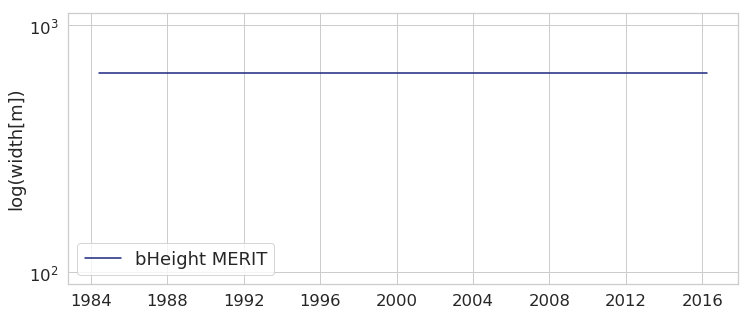

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
# maxseg = width_table.loc[:, width_table.max() == width_table.max().max()]
# maxseg = maxseg.columns
maxseg = "63_1905"
grids = mapped_grids[mapped_css.index(maxseg)]
lon, lat = [int(num) for num in grids.split("_")]
rivwth = np.fromfile("../../../model/CaMa-Flood_v395b_20191030/map/MSR_03min/rivwth_gwdlr.bin", np.float32).reshape(nlat, nlon)[lat, lon]
maxseg_timeseries = width_table.loc[:, maxseg].dropna()
plt.figure(figsize=(12,5))
# plt.scatter(maxseg_timeseries.index, maxseg_timeseries.values, label="landsat", marker="+", color="#FF5733")
plt.plot(maxseg_timeseries.index, np.ones(len(maxseg_timeseries))*rivwth, label="bHeight MERIT", color="#1a237e")
plt.yscale("log")
plt.legend(loc="lower left", fontsize=18)
plt.ylabel("log(width[m])", fontsize=18)
# plt.savefig("landsat_merit_comparison.jpg", dpi=500, bbox_inches="tight", pad_inches=0.1)
plt.savefig("merit_stndaln.jpg", dpi=500, bbox_inches="tight", pad_inches=0.1)

In [16]:
(np.array(mapped_csv["segment_keys"].values) == np.array(width_table.columns.values)).any()

True

In [17]:
vecid = [dautils.getvecid(int(e.split("_")[1]), int(e.split("_")[0]), map2vec) for e in mapped_grids.tolist()[1::]]
gridlons = [int(e.split("_")[0]) for e in mapped_grids.tolist()[1::]]
gridlats = [int(e.split("_")[1]) for e in mapped_grids.tolist()[1::]]
vecid
width_table = width_table.iloc[:, 1::]
width_table.columns = vecid

In [19]:
import xarray as xr
import pytz
perror = 10
widtharray = width_table.values.reshape(1,len(width_table),386)
dates = width_table.index.tolist()
print(widtharray.shape)
errorarray = widtharray*perror/100
widtharray[np.isnan(widtharray)] = undef
errorarray[np.isnan(errorarray)] = undef
outarray = np.vstack([widtharray, errorarray])
print(outarray.shape)
width_xr = xr.DataArray(outarray, coords={"kind":["values", "errors"], "time":dates, "vecid":vecid, "gridlon":(("vecid"), np.array(gridlons).astype(np.int32)), "gridlat":(("vecid"), np.array(gridlats).astype(np.int32))}, dims=["kind", "time", "vecid"])
width_xr.name = "outwth"
width_xr = width_xr.to_dataset()  # if you have multiple observation, add to dataset.
width_xr

(1, 4276, 386)
(2, 4276, 386)


<xarray.Dataset>
Dimensions:  (kind: 2, time: 4276, vecid: 386)
Coordinates:
  * kind     (kind) <U6 'values' 'errors'
  * time     (time) datetime64[ns] 1984-05-10 1984-05-16 ... 2016-04-28
  * vecid    (vecid) int32 18640 18975 6677 18977 ... 18300 18301 18303 18638
    gridlon  (vecid) int32 100 101 103 103 104 104 105 ... 88 90 91 93 94 96 98
    gridlat  (vecid) int32 84 85 42 85 42 85 42 86 ... 82 81 81 82 83 83 83 84
Data variables:
    outwth   (kind, time, vecid) float64 -9.999e+03 -9.999e+03 ... -9.999e+03

In [20]:
!rm "mapout/landsat_19840501_20160429_MSR_03min.nc"
width_xr.to_netcdf("mapout/landsat_19840501_20160429_MSR_03min.nc")

In [21]:
width_xr["outwth"].sel(time=datetime.datetime(2016,4,7), kind="errors").values.shape

(386,)

In [22]:
import h5py
with h5py.File("./mapout/vecmapinfo.hdf5", "w") as f:
    dset_map2vec = f.create_dataset("map2vec", (nlat,nlon), dtype=np.int32, data=map2vec)
    dset_vec2lat = f.create_dataset("vec2lat", (len(vec2lat),), dtype=np.int32, data=vec2lat)
    dset_vec2lon = f.create_dataset("vec2lon", (len(vec2lon),), dtype=np.int32, data=vec2lon)
    
    dset_map2vec = map2vec[:,:]
    dset_vec2lat = vec2lat
    dset_vec2lon = vec2lon

In [23]:
with h5py.File("./mapout/vecmapinfo.hdf5", "r") as f:
    for key in list(f.keys()):
        print(f[key][:])

[[-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 ...
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]]
[  3   3   3 ... 256 256 257]
[101 102 107 ... 446 447 416]
